Intro: In this project I will be working on image classification. I have decided to use a model called EfficientNetB0 and a preloaded dataset provided by tensorflow. The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. The main objective of this project is to classify images based off of our model obtained by EfficientNetB0. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization.

In [3]:
import tensorflow as tf
print(tf.__version__)


2.16.1


In [4]:
from tensorflow.keras.applications import EfficientNetB0
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

Below we will be defining some constants before getting into the data pre-processing. Here in this code I set up and load the data using the handy tool from tesnorflow. I am able to look up the dataset stanford_dogs without having to manually install the dataset onto my computer.

About 20,000 images that belong to 120 classes of dog breeds are in this data set and there is about 12k images for training and 8k images for testing.

In [5]:
#EfficientNet model determines IMG_SIZE 
IMG_SIZE = 224
BATCH_SIZE = 64


dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes
print(f"Number of classes: {NUM_CLASSES}")


Number of classes: 120


We begin the data preprocessing here by resizing the images for the EfficientNet model. 

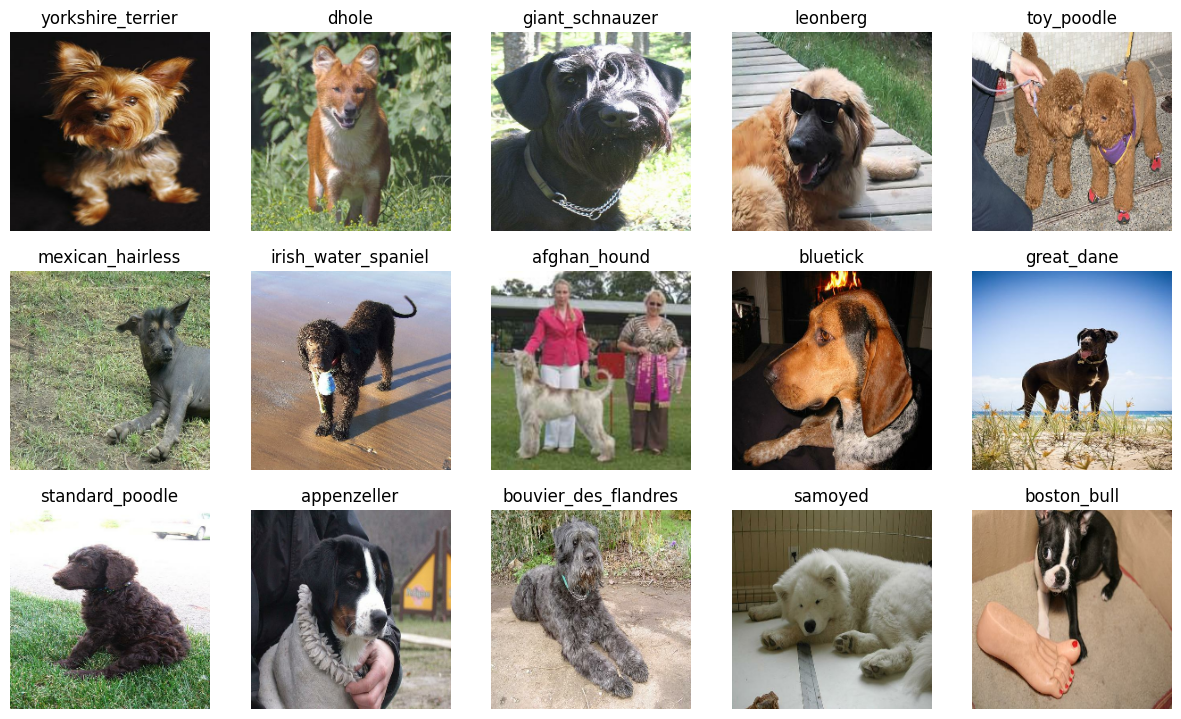

In [6]:
def resize_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

ds_train = ds_train.map(resize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(resize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

def format_label(label):
    string_label = ds_info.features["label"].int2str(label)
    return string_label.split("-")[1]

# Increase the number of images displayed
num_images = 15

plt.figure(figsize=(15, 15))
for i, (image, label) in enumerate(ds_train.take(num_images)):
    ax = plt.subplot(5, 5, i + 1)  # Adjust the grid to 5x5
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(format_label(label))
    plt.axis("off")
plt.show()


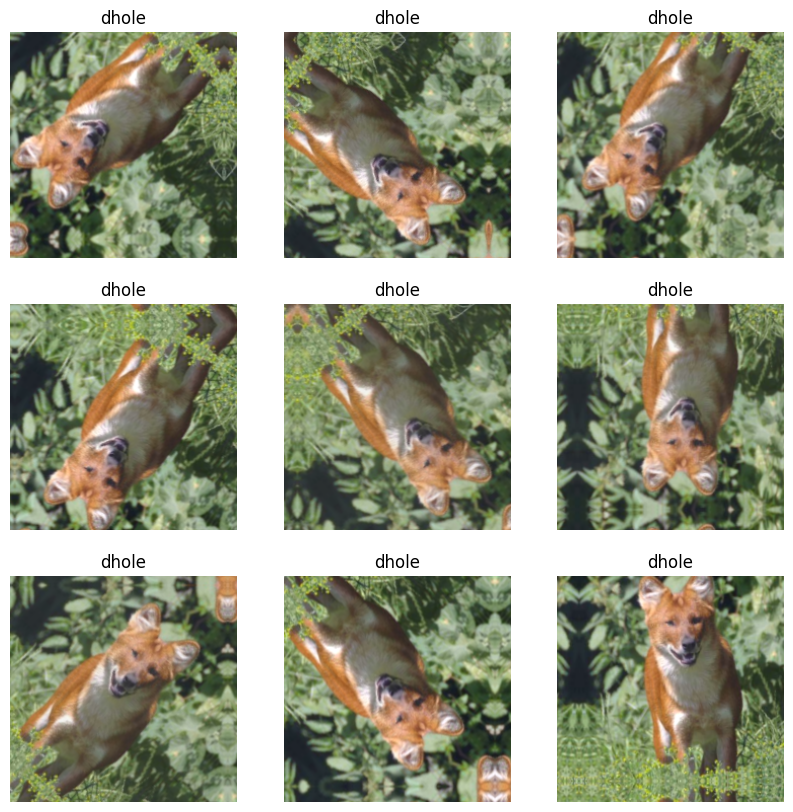

In [5]:
# There are images of various sizes so we need to resize them needed for EfficientNet
mg_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images
# Visualize augmented images for the second image in the dataset
for idx, (image, label) in enumerate(ds_train.take(2)):
    if idx == 1:  # Select the second image
        plt.figure(figsize=(10, 10))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            aug_img = img_augmentation(tf.expand_dims(image, axis=0))
            plt.imshow(aug_img[0].numpy().astype("uint8"))
            plt.title(format_label(label))
            plt.axis("off")
        plt.show()



This section below is used for preparing the data for training. The categorical encoding used will be One-Hot for the batched dataset.

Also note that the parameters prefecth and autune may improve performace so I am testing that out here.

In [6]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In this section we train our model and build an EfficientNetB0 with 120 output classes. 5 Epochs are chosen because the slow speeds of my computer.

In [7]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

epochs = 5
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization_2[… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 4,203,291 (16.03 MB)

 Trainable params: 4,161,268 (15.87 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 2575s 14s/step - accuracy: 0.0098 - loss: 5.0866 - val_accuracy: 0.0058 - val_loss: 5.1951
Epoch 2/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 2283s 12s/step - accuracy: 0.0186 - loss: 4.7030 - val_accuracy: 0.0155 - val_loss: 5.2593
Epoch 3/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 2192s 12s/step - accuracy: 0.0329 - loss: 4.5032 - val_accuracy: 0.0347 - val_loss: 4.7278
Epoch 4/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 2183s 12s/step - accuracy: 0.0403 - loss: 4.3815 - val_accuracy: 0.0352 - val_loss: 4.6488
Epoch 5/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 2274s 12s/step - accuracy: 0.0474 - loss: 4.2729 - val_accuracy: 0.0496 - val_loss: 4.4011


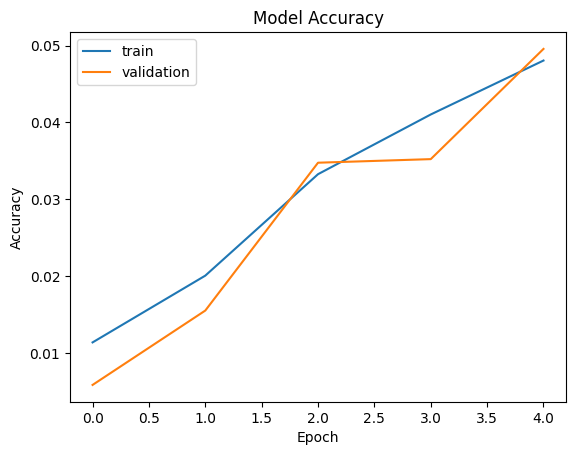

In [8]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

From the results above we see that the validation results are not as stable as the training results at first as the numbers of epochs increase. The accuracy does continously increase as expected.

In this section we initialize the model again but this time with pre-trained ImageNet weights and then perform some fine tuning on our dataset. 

A notable action is freezing the layers and training only the top layers. I predict that the convergence will be notable at larger epochs but I am constrained by time and performance of my hardware so therefore I will continue to use 4 epochs.

Model: "EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          7 │ rescaling_5[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 224, 224,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_6[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,208,411 (16.05 MB)

 Trainable params: 156,280 (610.47 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

Epoch 1/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 625s 3s/step - accuracy: 0.1474 - loss: 4.1264 - val_accuracy: 0.6950 - val_loss: 1.3545
Epoch 2/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 667s 4s/step - accuracy: 0.4278 - loss: 2.1898 - val_accuracy: 0.7352 - val_loss: 0.8672
Epoch 3/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 735s 4s/step - accuracy: 0.4913 - loss: 1.9032 - val_accuracy: 0.7599 - val_loss: 0.7798
Epoch 4/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 680s 4s/step - accuracy: 0.5222 - loss: 1.7686 - val_accuracy: 0.7646 - val_loss: 0.7637


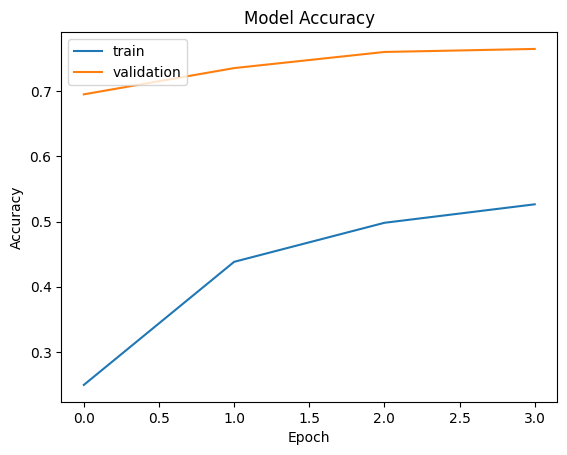

In [9]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet')

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.3  #drop out rate tuning
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compiling
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)  #learing rate
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = build_model(num_classes=NUM_CLASSES)
model.summary()

epochs = 4
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)

Upon doing the finetuning and freezing the layers, we see that we get much higher accuracy in the validation results compared to the training results. I believe this to be the case because of the strong regularization. There is also a difference in training-time so I believe this to be more efficient. 

In this next model iteration with more fine tuning we use an even small learning rate and also unfreeze the top 20 layers. I still expect some good resulst since ImageNet pretraining has already been exposed to many dogs. 

However in the pretrained weights model version the finetuning can play more crucial role. EfficientNetB0 can really make the difference that can also be seen with training time as well.

Epoch 1/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 767s 4s/step - accuracy: 0.5868 - loss: 1.5087 - val_accuracy: 0.7839 - val_loss: 0.7041
Epoch 2/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 831s 4s/step - accuracy: 0.5872 - loss: 1.4719 - val_accuracy: 0.7850 - val_loss: 0.6988
Epoch 3/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 822s 4s/step - accuracy: 0.5963 - loss: 1.4390 - val_accuracy: 0.7861 - val_loss: 0.6950
Epoch 4/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 768s 4s/step - accuracy: 0.6040 - loss: 1.4144 - val_accuracy: 0.7880 - val_loss: 0.6934


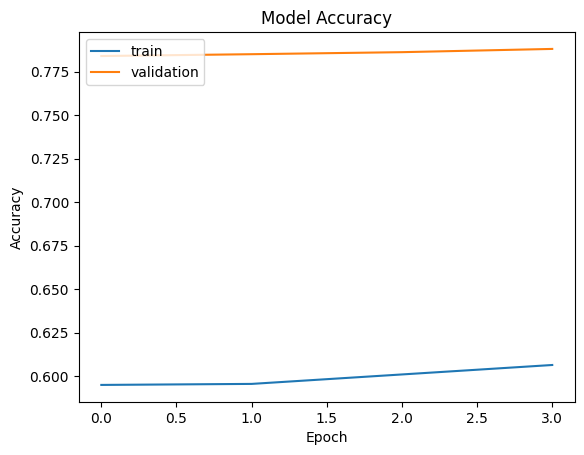

In [14]:
def unfreeze_model(model):
    # Unfreeze the top 20 layers while keeping BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # Compilingthe model with a smaller learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

unfreeze_model(model)

# Training the model  after unfreezing
epochs = 4  # keeping the same
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)

In the results above we can clearly see that the validation accuracy is even greater than the previous runs compared to the training results.

Conclusion: 
Instead of unfreezing all layers, unfreezing only the top layers or a subset of layers can make fine-tuning faster and more stable especially for larger models. Another thing I could have considered for tuning could have been an Estimated Moving Average. This can be very helpful in stabilizing training by averaging model weights over iterations. This is particularly useful when training from scratch but less so for transfer learning. I also believe that using a smaller batch size can help in achieving better validation accuracy due to effective regularization.

Overall, using the EfficientNet model was efficient compared to using other training methods as shown above.